In [1]:
%load_ext watermark
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from sklearn.ensemble import RandomForestRegressor

from typing import List
from scipy.stats import beta
from scipy.stats import multinomial

from myst_nb import glue
from slugify import slugify

import plastockconf as psc
import plastock as pstk

from plastockconf import name_zones, name_frequentation, name_situation
from plastockconf import name_substrate, name_distance, table_css_styles, table_css_styles_top

from plastock import capitalize_x_tick_labels, capitalize_x_and_y_axis_labels, capitalize_legend_components, attribute_summary, add_table_to_page

import reportclass as rc

section = "RP"
page = ""

def make_exportable(data, file_name, cmap='YlOrBr'):
    data.fillna(0, inplace=True)
    fig, ax = plt.subplots(figsize=(12,8))
    sns.heatmap(data=data, vmin=0, vmax=1, cmap=cmap, annot=True, fmt='.2', annot_kws={'size':10}, ax=ax, cbar=False)
    plt.tight_layout()
    ax.tick_params(which='both', axis='both', bottom=False, left=False)
    plt.savefig(file_name, dpi=300)

    plt.close()
    
glue('blank_caption', " ", display=False)

In [2]:
# reading in data
# new_data = pd.read_csv("data/end_pipe/macro_current.csv")
work_data = pd.read_csv("data/end_pipe/macro_data_linearm.csv")
beach_data = pd.read_csv("data/end_pipe/pstock_beaches_current.csv")

# historical data
hist_leman = pd.read_csv("data/end_pipe/hist_leman.csv")
# ghi = pd.read_csv('data/end_pipe/iqaasl.csv')
hiqaasl = hist_leman[hist_leman.project == "IQAASL"].copy()
hiqaasl.rename(columns={"sample_id":"loc_date", "location":"slug", 'pcs/m':'pcs_m'}, inplace=True)
iq_cols = ['loc_date', 'date', 'slug', 'code', 'quantity', 'city', 'feature_name', 'feature_type', 'parent_boundary', 'pcs_m', 'project']

ghi = hiqaasl[iq_cols].copy()



# most recent results not plastock
ssp=pd.read_csv('data/end_pipe/swt_all.csv')

# the independent variables are in asl_beaches file
beach_data_f = pd.read_csv("data/end_pipe/asl_beaches.csv").set_index('Plage')

# code definitions
codes = pd.read_csv('data/end_pipe/codes.csv').set_index('code')

# add the regional component
# the regional labels for each survey location
regions = pd.read_csv("data/end_pipe/lac_leman_regions.csv")
regions.set_index('slug', drop=True, inplace=True)

# the city designation is used for reporting
# the city name of the survey locations
city_map = pd.read_csv('data/end_pipe/city_map.csv')
city_map.set_index('slug', inplace=True)

codes_ip = work_data.code.unique()

In [3]:
# !important formatting data for use with IQAASL
# when combined with previous data there are duplicate location names
# the locations in plastock data that have the same name as iqaasl data
# need to be changed so we can use the reporting scheme from IQAASL
change_names = ['preverenges', 'tolochenaz', 'versoix', 'vidy', 'cully']

plastock_cols = ['loc_date', 'date','slug','region', 'code', 'quantity', 'city', 'feature_name', 'feature_type','parent_boundary', 'pcs_m']
features = ['frequentation', 'situation', 'orientation', 'distance']

changeus = work_data[work_data.slug.isin(change_names)].copy()
donotchange = work_data[~work_data.slug.isin(change_names)].copy()

new_slug = {
    'cully': 'cully-p',
    'preverenges': 'preverenges-p',
    'tolochenaz': 'tolochenaz-p',
    'versoix':'versoix-p',
    'vidy': 'vidy-p'}

# they have the same name as locations in iqaasl
changeus['new_slug'] = changeus.slug.apply(lambda x: new_slug[x])
changeus['slug'] = changeus.new_slug
changeus.drop('new_slug', inplace=True, axis=1)

# the plastock data with the converted names
wd_nn = pd.concat([changeus, donotchange])

# # plastock did not use the same inventory as iqaasl
# # here we select only the codes in the plastock inventory
# pcodes = wd_nn.code.unique()

# identify and remove codes for which there is no defintion
# if the code is not defined then it can not be used
t = [x for x in codes_ip if x not in codes.index]
wd_ni = wd_nn[~wd_nn.code.isin(t)].copy()


# ! aggregating plastic caps, fragmented plastics, fragmented foams !
# these items are not well divided into the composite subgroups
# for example people often know what a cap is, but whether it 
# comes from a drink bottle or other type is not well considered
# we combine the subcategories into more comprehensive groups.
ti = rc.use_gfrags_gfoams_gcaps(wd_ni, codes)


# formatting data for reporting
# aggregate along all land-use and topo variables.
ti = ti.groupby(['échantillon', 'Plage', 'region', 'date', 'substrat', 'length', 'slug', 'code'], as_index=False).agg({'quantité':'sum'})

# !combinining with previous results!
# these are the default arguments for the report class
# the language maps gives the code definitions in english, german and french
# the top_label asserts the top level aggregation for the set of data defined by
# start, end dates and feature_name. These arguments are for the plastock data
language_maps = rc.language_maps()
top_label= ['feature_name', 'lac-leman']

# the default language is english in the report column class
# there are column names that need to be changed
new_names = {'échantillon': 'loc_date', 'pcs/m': 'pcs_m'}
ti.rename(columns={**new_names,'quantité': 'quantity'}, inplace=True)

# define the pcs/m column and the data to merge
ti['pcs_m'] = ti.quantity/ti.length

# adding and renaming columns according to reportclass requirements
# these values can be indexed on the IQAASL data
ti['city'] = ti.slug.apply(lambda x: city_map.loc[x])
ti['feature_name'] = 'lac-leman'
ti['feature_type'] = 'l'
ti['parent_boundary'] = 'rhone'

# ! adding feature columns to survey data !
# they can be merged on the Plage column and the index
# these are used for modeling
env_plastock = ti.merge(beach_data_f[features], left_on='Plage', right_index=True)
env_plastock = env_plastock[[*plastock_cols, *features, 'substrat']]

# ! the data for reporting !
ti_work = ti[plastock_cols].copy()

# this data is formatted to work with the reporting structure of IQAASL
# the landuse data is not included here.
ti_work = ti_work.groupby(plastock_cols, as_index=False).agg(psc.unit_agg)
ti_work['project']='Plastock'

# merge the data and select only the current codes from plastock
txi = pd.concat([ghi, ti_work[[*plastock_cols, 'project']].copy()])
txi.reset_index(inplace=True)
txi = txi[txi.code.isin(ti_work.code.unique())]

# a report that includes both sets of data
boundaries = dict(start_date="2020-04-01", end_date="2023-01-01", feature_name="lac-leman", language="fr")
report_iq_pk = rc.ReportClass(txi.copy(), boundaries=boundaries, language="fr", lang_maps=language_maps, top_label=top_label)

# a report that includes just plastock data
boundaries = dict(start_date="2021-12-31", end_date="2023-01-01", feature_name="lac-leman", language="fr")
plastock_report = rc.ReportClass(ti_work.copy(), boundaries=boundaries, language="fr", lang_maps=language_maps, top_label=top_label)

display_language = plastock_report.language
display_language_map = plastock_report.lang_maps[display_language]

In [4]:
# ! creation of composite variables !

operations =  {'échantillon':'nunique', 'pcs_m':'median'}

def make_categorical_matrix(data: pd.DataFrame = None, feature_columns: list = None, operations: dict = operations):    
    # executes a pd.DataFrame.groupby operation on data feature_columns using operations  
    nd = data.groupby(feature_columns, as_index=False).agg(operations)    
    
    return nd


def name_the_new_distance(x, less='<= 500 m', more = '> 500 m'):
    if x == 1:
        return less
    else:
        return more

def name_the_new_freq(x, new):
    if x <= 2:
        return new
    else:
        return 'Elévée'    

# a data frame to combine variables and apply to the survey data
t_and_f = env_plastock.loc[:, ['loc_date', 'slug','date','code', 'pcs_m', 'quantity', 'frequentation', 'situation', 'distance', 'substrat']].copy()

# the substrat and distance features are being combined from four two
# by combining the two lowest and the two highest of each group.
# substrat is now sand or gravel
# distance is now within 500 meters or not
# frequentation is combined in to two groups. the two lowest groups are combined
t_and_f.loc[t_and_f.substrat <= 2, 'substrat'] = 1
t_and_f.loc[t_and_f.substrat > 2, 'substrat'] = 2
t_and_f.loc[t_and_f.distance <= 2, 'distance'] = 1
t_and_f.loc[t_and_f.distance > 2, 'distance'] = 2
t_and_f.loc[t_and_f.frequentation <= 2, 'frequentation'] = 2

f_combi = t_and_f.copy()

f_combi.rename(columns={'frequentation':'fréquentation', 'loc_date': 'échantillon'}, inplace=True)

# the data-frame with composite variables
f_comb = f_combi.copy()
f_comb['distance'] = f_comb['distance'].apply(lambda x: name_the_new_distance(x))
f_comb['fréquentation'] = f_comb['fréquentation'].apply(lambda x: name_the_new_freq(x, 'faible-moyenne'))
f_comb['situation'] = f_comb['situation'].apply(lambda x: name_situation[x])
f_comb['substrat'] = f_comb['substrat'].apply(lambda x: name_the_new_distance(x, less='Sable', more='Graviers'))

# used to visualise the results of the new groups
f_freq_sub = make_categorical_matrix(data=f_comb, feature_columns=['fréquentation', 'substrat'])
f_freq_sit = make_categorical_matrix(data=f_comb, feature_columns=['fréquentation', 'situation'])
f_freq_dist = make_categorical_matrix(data=f_comb, feature_columns=['fréquentation', 'distance'])

# The work data for the GPT. The data of reference.
# The independent variables have not been changed
no_combined = env_plastock.loc[:, ['loc_date', 'slug','date','code', 'pcs_m', 'frequentation', 'situation', 'distance', 'substrat']].copy()
no_combined.rename(columns={'frequentation':'fréquentation', 'loc_date': 'échantillon'}, inplace=True)
# for the GPT:
no_combined.to_csv('plastock_with _asl_landuse.csv', index=False)
no_combined['distance'] = no_combined['distance'].apply(lambda x: name_distance[x])
no_combined['fréquentation'] = no_combined['fréquentation'].apply(lambda x: name_frequentation[x])
no_combined['situation'] = no_combined['situation'].apply(lambda x: name_situation[x])
no_combined['substrat'] = no_combined['substrat'].apply(lambda x: name_substrate[x])

In [5]:
# ! checking the equality under different scenarios !

def check_dfs(df, label, samps='echanitllon', pcs='pcs_m'):
    dts = df.groupby([samps, 'slug'], as_index=False)[pcs].sum()
    quants = dts[pcs].quantile([.05, .25, .5, .75, .95])
    sampls =dts[samps].nunique()
    
    # print(f'\n{label}: \n{quants}\n{sampls}')
    
    return quants, sampls

nc_q, nc_samps = check_dfs(no_combined, 'not combined',  samps='échantillon')
fcmb_q, fcmb_samps = check_dfs(f_combi, 'combined', samps='échantillon')
tf_q, tf_samps = check_dfs(t_and_f,'feature_t', samps='loc_date')
ti_q, ti_samps = check_dfs(ti_work,'report data', samps='loc_date')
trc, trc_s = check_dfs(plastock_report.w_df, 'report df', samps='loc_date')

In [6]:
# ! the historical data used for the resume !
hist_leman.rename(columns={"sample_id":"loc_date", "location":"slug", "pcs/m":"pcs_m"}, inplace=True)

hist_leman.loc[hist_leman.slug == 'preverenges', 'region'] = 'Grand lac'
hist_leman.loc[hist_leman.slug == 'tolochenaz', 'region'] = 'Grand lac'
hist_leman.loc[hist_leman.slug == 'versoix', 'region'] = 'Grand lac'
hist_leman.loc[hist_leman.slug == 'vidy', 'region'] = 'Grand lac'

lh_df = pd.concat([hist_leman[hist_leman.code.isin(ti_work.code.unique())].copy(), ti_work])
lh_df["date"] = pd.to_datetime(lh_df["date"])

slh = lh_df[lh_df.city == 'Saint-Sulpice (VD)'].loc_date.unique()

keep = [x for x in ssp.loc_date.unique() if x not in slh]
ssp_2022 = ssp[ssp.loc_date.isin(keep)].copy()
ssp_2022.rename(columns={'pcs/m':'pcs_m'}, inplace=True)
ssp_2022['date'] = pd.to_datetime(ssp_2022['date'])
ssp_dt = ssp_2022.groupby(['loc_date', 'date'], as_index=False).pcs_m.sum()


these_codes = ['Gfrags', 'G27', 'G30', 'Gfoams', 'Gcaps', 'G95', 'G112', 'G74', 'G89', 'G31']
order = ['MCBP', 'SLR', 'IQAASL', 'Solid-Waste-Team', 'Plastock']
summary_index = ['min', '25%', '50%', '75%', 'max', 'mean', 'std', 'count', 'total']

lh_df_dt = lh_df[lh_df.code.isin(these_codes)].groupby(['loc_date','date', 'region', 'project'], as_index=False).agg({'pcs_m':'sum'})

In [7]:
# the scatterplot of all samples
fig, ax = plt.subplots(figsize=(8,6))
ms = 6

markers = {'Grand lac':'+', 'Petit lac':'x', 'Haut lac':'s'}
colors = {"Plastock": "peru", "IQAASL":"darkorange", "MCBP": "olive", "SLR":"darkcyan", "Solid-Waste-Team":"dodgerblue", "Résultats 2022, non Plastock":"magenta"}
edge_colors = {'Grand lac':'darkolivegreen', 'Petit lac':'darkcyan', 'Haut lac':'indigo'}

sns.scatterplot(data=lh_df_dt, x='date', y='pcs_m', hue='project', hue_order=order[::-1], marker='x', linewidth=1, palette=colors, ax=ax)
sns.scatterplot(data=ssp_dt, x='date', y='pcs_m', ax=ax, marker='x', color='magenta', linewidth=1.2, label="Résultats 2022, non Plastock", zorder=2)
h, l = ax.get_legend_handles_labels()
h= [Line2D([0], [0], linewidth=0, label=x, marker='x', markersize=ms, markeredgecolor=colors[x], markerfacecolor=colors[x]) for x in l]
ax.legend(h, l,bbox_to_anchor=(.5,1), loc='upper center')
ax.set_ylim(-.5, 30)
ax.set_ylabel('pcs/m')
ax.set_xlabel('')
plt.tight_layout()


glue('hist_leman', fig, display=False)

plt.close()

In [8]:
# report class of historical data
boundaries = dict(start_date="2015-11-01", end_date="2023-01-01", feature_name="lac-leman", language="fr")
t_report = rc.ReportClass(lh_df[lh_df.code.isin(ti_work.code.unique())].copy(), boundaries=boundaries, language="fr", lang_maps=language_maps, top_label=top_label)

groups_df = t_report.w_df.copy()
group_name_map = codes['groupname']
groups_df['groupname'] = groups_df.code.apply(lambda x: group_name_map.loc[x])
groups_df['date'] = pd.to_datetime(groups_df["date"])

# the disitribution of the sample total for each epoch
group_results = t_report.summarize_feature_labels(feature='project')
group_results.columns = group_results.columns.droplevel(0)
group_results = group_results.reindex(summary_index)

gr_res = group_results[order].copy() 
gr_res = rc.translated_and_style_for_display(gr_res, display_language_map, display_language, gradient=False)
gr_res = gr_res.highlight_max(axis=1, props= 'color: rgba(255, 0, 0, 1);')

caption = "résultats Lac Léman 2015 - 2022, déchets pour un métre de rivage. Les dates sont désignées par le nom de la campagne. La campagne la plus ancienne est MCBP." 
gr_res = pstk.add_table_to_page(gr_res, 1, caption, section, page, "", format_index=None)
glue('gr_res', gr_res, display=False)

In [9]:
# the median sample result of the most common codes from 2022
# since 2015, using the historical report
t = rc.a_cumulative_report(t_report.w_df[t_report.w_df.code.isin(these_codes)].copy(), feature_name='project', object_column='code')

mc_historical = rc.translated_and_style_for_display(t[[*order, 'all']], display_language_map, display_language, gradient=False) 

mc_historical = mc_historical.highlight_max(axis=1, props= 'color: rgba(255, 0, 0, 1);')

caption = "les résultats historiques des objets les plus courants de Plastock. Les GPI n'ont pas été comptés (identifiés) lors des deux premières campagnes d'échantillonnage."
mc_historical = pstk.add_table_to_page(mc_historical, 2, caption, section, page, "", format_index=None)
glue('mc_historical', mc_historical, display=False)

In [10]:
# the median code group results, hsitorical data
cg_hist = rc.a_cumulative_report(groups_df, feature_name='project', object_column='groupname')
cg_hist = rc.translated_and_style_for_display(cg_hist[[*order, 'all']], display_language_map, display_language, gradient=False) 

cg_hist = cg_hist.highlight_max(axis=1, props= 'color: rgba(255, 0, 0, 1);')

caption = "objets groupés selon l'utilisation et la description 2015 - 2022. Il est à noter que tant le solid-waste-team que Plastock enregistrent un nombre d'objets tabaco plus faible et plus de plastiques fragmentés."
cg_hist = pstk.add_table_to_page(cg_hist, 3, caption, section, page, "", format_index=None)
glue('cg_hist', cg_hist, display=False)

In [11]:
# regional results prior to 2022, not including plastock
data_y = t_report.w_df[t_report.w_df.code.isin(these_codes)].copy()
data_y = data_y[data_y.project != 'Plastock'].copy()
t = rc.a_cumulative_report(data_y, feature_name='region', object_column='code')

mc_region = rc.translated_and_style_for_display(t, display_language_map, display_language, gradient=False)

caption = "<b>Plastock non inclus</b> médiane des résultats précédents des objets les plus courants par région."

mc_region = mc_region.highlight_max(axis=1, props= 'color: rgba(255, 0, 0, 1);')
mc_region = pstk.add_table_to_page(mc_region, 4, caption, section, page, "", format_index=None)
glue('mc_region', mc_region, display=False)

In [12]:
# Plastock regional results
gh = t_report.w_df[t_report.w_df.project == 'Plastock'].copy()
gh = rc.a_cumulative_report(gh[gh.code.isin(these_codes)].copy(), feature_name='region', object_column='code')
gh = rc.translated_and_style_for_display(gh, display_language_map, display_language, gradient=False)
gh = gh.highlight_max(axis=1, props= 'color: rgba(255, 0, 0, 1);')

caption = "<b>Plastock </b> médian de pièces/m des objets les plus courants par région"
gh = pstk.add_table_to_page(gh, 5, caption, section, page, "", format_index=None)
glue('pstock_region', gh, display=False)

<!-- #### Distribution des plus courants pour chaque projet. -->

<!-- ## Situation

Les déchets sauvages ont été collectés dans 25 emplacements différents autour du Léman. Soixante-sept sur 98 de ces emplacements se trouvaient dans des zones urbaines, avec un taux d'utilisation élevé de 55 sur 98, et 83 sur 98 étaient situés à moins de 500 mètres d'un parking. Les caractéristiques ont été notées par les personnes chargées de la collecte des déchets sauvages [Macro déchets plage et attribut](macro-attributes).

### Les résultats -->

In [13]:
# summary of plastock sample totals
comp_summary = plastock_report.summarize_feature_labels(feature='feature_name')
t = rc.translated_and_style_for_display(comp_summary.copy(),  display_language_map, display_language, gradient=False)
rep_res_one = "L'échantillonnage était planifié trimestriellement, commençant en janvier 2022. À quelques exceptions près, chaque emplacement était échantillonné quatre fois au cours de la période de 12 mois. Les études précédentes sur le lac étaient mensuelles ou aléatoires."
rep_res_two = "La médiane du total des échantillons était de 2 pièces/mètre avec une variance de 3,6 pièces/mètre."

caption = ""


t = pstk.add_table_to_page(t, 6, caption, section, page, "", format_index=None)

glue('rep_results_one',rep_res_one , display=False)
glue('rep_results_two',rep_res_two , display=False)
glue('rep_results', t, display=False)

In [14]:
# most common codes from plastock
most_common, weight = plastock_report.most_common
xi = rc.translated_and_style_for_display(most_common.copy(),  display_language_map, display_language, gradient=False)
caption = "les objets les plus courants Plastock"

xi = pstk.add_table_to_page(xi, 7, caption, section, page, "", format_index=None)
glue('mc_pstock', xi, display=False)

In [15]:
# most common codes by city
w_df = plastock_report.w_df.copy()
cities = w_df.city.unique()
cone = cities[:12]
ctwo = cities[12:]

t = rc.a_cumulative_report(w_df[(w_df.code.isin(most_common.index))], feature_name='city', object_column='code', table_split=cone)

file_name = 'resources/images/most_common_one.jpg'
make_exportable(t, file_name)
caption = "Les résultats des objets les plus courants de Plastock pour chaque ville du projet: Amphion à Hemance"

pr_mc_cone = rc.translated_and_style_for_display(t, display_language_map, display_language, gradient=True)

pr_mc_cone = pstk.add_table_to_page(pr_mc_cone, 8, caption, section, page, "", format_index=None)

glue('pr_mc_cone', pr_mc_cone, display=False)

<!-- <br>
<br>
Résultats de Lugrin à Vidy : -->

In [16]:
# most common codes by city
t = rc.a_cumulative_report(w_df[(w_df.code.isin(most_common.index))], feature_name='city', object_column='code', table_split=ctwo)
file_name = 'resources/images/most_common_two.jpg'
make_exportable(t, file_name)

caption = "Les résultats des objets les plus courants de Plastock pour chaque ville du projet: Lugrin à Vidy"

pr_mc_ctwo = rc.translated_and_style_for_display(t, display_language_map, display_language, gradient=True)

pr_mc_ctwo = pstk.add_table_to_page(pr_mc_ctwo, 9, caption, section, page, "", format_index=None)
glue('pr_mc_ctwo', pr_mc_ctwo, display=False)

In [17]:
# code group results by city
groups_df = plastock_report.w_df.copy()
group_name_map = codes['groupname']
groups_df['groupname'] = groups_df.code.apply(lambda x: group_name_map.loc[x])

tg1 = rc.a_cumulative_report(groups_df, feature_name='city', object_column='groupname', table_split=cone)
file_name = 'resources/images/group_names_one.jpg'
make_exportable(tg1, file_name)

caption = "Les résultats des objets par utilisation pour chaque ville du projet: Amphion à Hemance"

code_group_results_cone = rc.translated_and_style_for_display(tg1, display_language_map, display_language, gradient=True)
code_group_results_cone = pstk.add_table_to_page(code_group_results_cone, 10, caption, section, page, "", format_index=None)
glue('pr_code_group_cone', code_group_results_cone, display=False)

In [18]:
# code group results by city
tg2 = rc.a_cumulative_report(groups_df, feature_name='city', object_column='groupname', table_split=ctwo)
file_name = 'resources/images/group_names_two.jpg'
make_exportable(tg2, file_name)

caption = "Les résultats des objets par utilisation pour chaque ville du projet: Lugrin à Vidy"

code_group_results_ctwo = rc.translated_and_style_for_display(tg2, display_language_map, display_language, gradient=True)


code_group_results_ctwo = pstk.add_table_to_page(code_group_results_ctwo, 11, caption, section, page, "", format_index=None)
glue('pr_code_group_ctwo', code_group_results_ctwo, display=False)

In [19]:
# summary of plastock sample totals
comb_dt = plastock_report.w_df
comb_dt = comb_dt.groupby(['loc_date', 'date', 'project'], as_index=False).pcs_m.sum()
comb_dt["date"] = pd.to_datetime(comb_dt["date"])

fig, ax = plt.subplots(2,2, figsize=(8,8))

sns.scatterplot(data=comb_dt, x="date", y="pcs_m", hue='project', ax=ax[0,0])
ax[0,0].set_title("Total par échantillon", loc="left")
ax[0,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax[0,0].xaxis.set_major_formatter(mdates.DateFormatter('%m-%y'))
ax[0,0].set_ylabel("pcs/m")
capitalize_x_and_y_axis_labels(ax[0,0])
capitalize_legend_components(ax[0, 0])

sns.boxplot(data=comb_dt, y="pcs_m", x='project', hue='project', dodge=False, width=.9, ax=ax[0,1])
ax[0,1].set_title("Boîte de Tukey", loc="left")
capitalize_x_and_y_axis_labels(ax[0,1])
ax[0,1].get_legend().remove()
ax[0,1].set_xlabel("")
ax[0,1].set_ylabel("pcs/m")

sns.histplot(data=comb_dt, x="pcs_m", ax=ax[1,0], stat="probability", hue='project', kde=True)
ax[1,0].yaxis.set_major_formatter('{x:.2f}')
ax[1,0].set_ylabel("Probabilité")
ax[1,0].set_xlabel("pcs/m")
ax[1,0].set_title("Histogramme", loc="left")
capitalize_x_and_y_axis_labels(ax[1,0])
ax[1, 0].get_legend().remove()

sns.ecdfplot(data=comb_dt, x="pcs_m", hue='project', ax=ax[1,1])
ax[1,1].set_title("Fonction de répartition", loc="left")
ax[1,1].set_xlabel("pcs/m")
capitalize_x_and_y_axis_labels(ax[1,1])
sns.move_legend(ax[1, 1], title=" ", loc='best')

plt.subplots_adjust(wspace=.3, hspace=.3)

glue('fig-D1', fig, display=False)
plt.close()

<!-- (sampling_conditions)=
## Les conditions d'échantillonnage

Les enquêteurs ont classé les conditions à chaque emplacement d'échantillonnage selon quatre catégories. :

1. distance au parking, du plus proche au plus éloigné (1-4)
2. utilisation : faible, moyenne, élevée (1-3)
3. substrat : sable fin à cailloux (1-4)
4. situation : campagne ou urbain (1-2) -->

In [20]:
# ! summarize the feature variables prior to creating composite

distance_index = ['< 100 m', '100 - 500 m', '500 - 1000 m',  '> 1000 m']
freq_index = ['Faible', 'Moyenne', 'Elevée']
sub_index =  ['Sables fins', 'Sables grossiers', 'Graviers', 'Cailloux']

# Calculate stats for each category with combined rows
frequentation_stats = pstk.calculate_combined_stats('fréquentation', data=no_combined.copy(), index=freq_index)
situation_stats = pstk.calculate_combined_stats('situation', data=no_combined.copy() )
distance_stats = pstk.calculate_combined_stats('distance', data=no_combined.copy(), index=distance_index)
substrat_stats = pstk.calculate_combined_stats('substrat', data=no_combined.copy(), index=sub_index)


freq_stats = pstk.add_table_to_page(frequentation_stats, 12, "Densité de déchets par fréquentation", section, page, "", format_index=None)
sit_stats = pstk.add_table_to_page(situation_stats, 13, "Densité de déchets par urbanization", section, page, "", format_index=None)
dist_stats = pstk.add_table_to_page(distance_stats, 14, "Densité de déchets par distance de parking", section, page, " ", format_index=None)
sub_stats = pstk.add_table_to_page(substrat_stats, 15, "Densité de déchets selon substrat", section, page, "", format_index=None)

glue('freq_stats', freq_stats, display=False)
glue('sit_stats', sit_stats, display=False)
glue('dist_stats', dist_stats, display=False)
glue('sub_stats', sub_stats, display=False)

<!-- ### Résumé comparatif :

1. Dans l'ensemble global, les plages très fréquentées (fréquentation 3) représentent plus de la moitié des échantillons. Cela peut influencer les résultats globaux.
2. Pour les plages très fréquentées, les moyennes pcs/m sont généralement plus élevées que dans l'ensemble global, indiquant une plus grande accumulation de débris.
3. La répartition entre les zones urbaines et rurales (situation) est presque égale parmi les plages très fréquentées, alors qu'elle est plus inclinée vers les zones rurales dans l'ensemble global.
4. En termes de substrat, les plages de sable sont les plus représentées dans les échantillons très fréquentés, ce qui est également observé dans l'ensemble global.

Ces différences mettent en évidence l'impact significatif de la fréquentation élevée sur la pollution des plages

#### Détail fréquentation élevée: -->

In [21]:
# detail of the results under elevated frequency scenario

freq_data = no_combined[no_combined['fréquentation'] == 'Elevée'].copy()

freq_sit = pstk.calculate_combined_stats('situation', data=freq_data)

freq_dist = pstk.calculate_combined_stats('distance', data=freq_data, index=['< 100 m', '100 - 500 m'])

freq_subs = pstk.calculate_combined_stats('substrat', data=freq_data)

freq_sit = pstk.add_table_to_page(freq_sit, 16, ": Densité de déchets par urbanisation, fréquentation élevée", section, page, "", format_index=None)
freq_dist = pstk.add_table_to_page(freq_dist, 17, ": Densité de déchets par distance de parking, fréquentation élevée", section, page, "", format_index=None)
freq_subs = pstk.add_table_to_page(freq_subs, 18, ": Densité de déchets selon substrat, fréquentation élevée", section, page, "", format_index=None)
glue('freq3_sit', freq_sit, display=False)
glue('freq3_subs', freq_subs, display=False)
glue('freq3_dist', freq_dist, display=False)

<!-- ## Les objets trouvés en fonction de leur utilisation

Le type d'utilité est basé sur l'utilisation de l'objet avant qu'il ne soit jeté ou sur la description de l'objet si l'utilisation initiale est indéterminée. Les objets trouvés sont classés dans l'une des 260 catégories prédéfinies. Les catégories sont regroupées en fonction de leur utilisation ou de leur description.

- Eaux usées : objets rejetés par les stations d'épuration, y compris les objets susceptibles d'être jetés dans les toilettes.
- Microplastiques (< 5 mm) : plastiques fragmentés et résines plastiques de préproduction.
- Infrastructure : objets liés à la construction et à l'entretien des bâtiments, des routes et des réseaux d'eau et d'électricité.
- Alimentation et boisson : tous les matériaux liés à la consommation de nourriture et de boissons.
- Agriculture : principalement des feuilles industrielles, par exemple, paillis et bâches de culture, serres, fumigation du sol, films d'emballage de balles. Comprend les plastiques durs pour les clôtures agricoles, les pots de fleurs, etc.
- Tabac : principalement des filtres de cigarettes, y compris tous les matériaux liés au tabagisme.
- Loisirs : objets liés au sport et aux loisirs, par exemple, pêche, chasse, randonnée, etc.
- Emballages non alimentaires et non liés au tabac : matériaux d'emballage non identifiés comme étant liés à la nourriture, aux boissons ou au tabac.
- Fragments de plastique : morceaux de plastique d'origine ou d'utilisation indéterminée.
- Objets personnels : accessoires, articles d'hygiène et vêtements.

Pour des informations détaillées sur la composition des groupes, consultez [IQAASL - DE](https://hammerdirt-analyst.github.io/IQAASL-End-0f-Sampling-2021/code_groups.html) ou [IQAASL - EN](https://www.plagespropres.ch/code_groups.html).
<br> -->

<!-- (most_common_p)=
## Les objets les plus courants Plastock

### Définition des _objets les plus courants_

Les _objets les plus courants_ peuvent être sélectionnés de plusieurs manières. On peut également les appeler les _objets d'intérêt_. Dans le cadre de ce rapport, nous nous concentrons sur les objets qui représentent une proportion plus importante des résultats que les autres. Nous avons utilisé deux critères de sélection : i. la quantité, ii. le taux d'échec.

1. Quanité: Si un objet a une quantité totale qui le place dans les dix premiers, il est considéré comme 'courant'.
2. Taux d'échec: Si un objet a été trouvé dans au moins la moitié des échantillons, il est ÉGALEMENT considéré comme 'courant'.

Par conséquent, pour cette étude, les 'objets les plus courants' sont ceux qui se trouvent soit dans les dix premiers en termes de nombre total de pièces de déchets ET/OU qui ont été trouvés dans au moins 50% des enquêtes. Pour Plastock, les objets les plus courants représentent 89% du montant total ou 24'156/27'493.

```{note}
Les équipes peuvent avoir d'autres critères pour s'intéresser à l'occurrence d'un objet dans l'environnement. Il s'agit d'un sujet qui devrait être largement développé au sein des équipes. 
``` -->

<!-- ### Les plus courants par ville

La densité médiane des objets les plus courants n'est pas la même pour chaque emplacement/municipalité, ce qui suggère une répartition géographiquement inégale de ces objets.

Résultats de Amphion à Hermance : -->

<!-- (cor_ospar)=
### Correspondance avec les résultats d'OSPAR

La Suisse et la France sont toutes deux parties contractantes de la convention [OSPAR](https://www.ospar.org/organisation/contracting-parties). Parmi les objets les plus courants identifiés à partir des données Plastock, six peuvent également être retrouvés dans le rapport d'état de qualité le plus récent d'OSPAR concernant l'Abondance, la Composition et les Tendances des [déchets sauvages](https://www.ospar.org/work-areas/eiha/marine-litter/assessment-of-marine-litter/beach-litter).

1. Fragments de plastique : g80, g79, g78, g77, g76, g75
2. Fragments de polystyrène expansé : g81, g82, g83
3. Couvercles en plastique de bouteille : g21, g22, g23, g24
4. Coton-tige
5. Emballages de bonbons, de snacks
6. Déchets de construction en plastique

```{note}
Les directives de surveillance d'OSPAR n'incluent pas les objets de moins de 5 mm. Par conséquent, des objets tels que les granulés industriels  (GPI) ou de petits morceaux de 5 mm ou moins ne figureront pas dans la liste des objets les plus courants d'OSPAR.

Selon le _Document de référence d'OSPAR sur les granulés plastiques pré-production_, [granulés OSPAR](https://www.ospar.org/documents?v=39764), entre 16 et 167 tonnes par an de GPI sont perdues dans l'environnement
```

### Correspondance avec l'IQAASL

Les objets les plus courants répertoriés pour le lac Léman en 2021 comprennent tous les objets les plus courants de Plastock à l'exception des 'Fragments de plastique angulaires <5 mm', [Lac Léman, IQAASL](https://hammerdirt-analyst.github.io/IQAASL-End-0f-Sampling-2021/lac-leman.html).

```{note}
Les protections féminines et applicateurs de tampons, des éléments importants parmi les objets les plus courants d'OSPAR et d'IQAASL, n'ont pas été identifiées lors des enquêtes Plastock.
``` -->

In [22]:
# a jpeg that directly compares the previous campaign to Plasotck
t = rc.a_cumulative_report(report_iq_pk.w_df[report_iq_pk.w_df.code.isin(most_common.index)], feature_name='project', object_column='code')
file_name = 'resources/images/most_common_iqaasl.jpg'
make_exportable(t, file_name)

<!-- (pstock_iqaasl)=
## Plastock - IQAASL

Plastock et IQAASL étaient deux projets distincts qui ont mesuré la même chose. En les combinant, ils offrent une représentation des conditions sur le littoral du lac pour la période allant d'avril 2020 à décembre 2022.

Dans cette section, nous comparons les résultats d'un projet à l'autre et les combinons pour définir les perspectives pour 2024. -->

In [23]:
# summary of the combined results of plastock and iqaasl
t = report_iq_pk.summarize_feature_labels(feature='project')
ti = rc.translated_and_style_for_display(t, display_language_map, display_language, gradient=False)
caption = ""

ti = pstk.add_table_to_page(ti, 19, caption, section, page, "", format_index=None)

glue('mc_pstock_results', ti, display=False)

In [24]:
# graphical summary of the sample results of iqaasl and plastock
comb_dt = report_iq_pk.w_df
comb_dt = comb_dt.groupby(['loc_date', 'date', 'project'], as_index=False).pcs_m.sum()
comb_dt["date"] = pd.to_datetime(comb_dt["date"])

fig, ax = plt.subplots(2,2, figsize=(8,8))

sns.scatterplot(data=comb_dt, x="date", y="pcs_m", hue='project', ax=ax[0,0])
ax[0,0].set_title("Total par échantillon", loc="left")
ax[0,0].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax[0,0].xaxis.set_major_formatter(mdates.DateFormatter('%m-%y'))
ax[0,0].set_ylabel("pcs/m")
capitalize_x_and_y_axis_labels(ax[0,0])
capitalize_legend_components(ax[0, 0])

sns.boxplot(data=comb_dt, y="pcs_m", x='project', hue='project', dodge=False, width=.9, ax=ax[0,1])
ax[0,1].set_title("Boîte de Tukey", loc="left")
capitalize_x_and_y_axis_labels(ax[0,1])
ax[0,1].get_legend().remove()
ax[0,1].set_xlabel("")
ax[0,1].set_ylabel("pcs/m")

sns.histplot(data=comb_dt, x="pcs_m", ax=ax[1,0], stat="probability", hue='project', kde=True)
ax[1,0].yaxis.set_major_formatter('{x:.2f}')
ax[1,0].set_ylabel("Probabilité")
ax[1,0].set_xlabel("pcs/m")
ax[1,0].set_title("Histogramme", loc="left")
capitalize_x_and_y_axis_labels(ax[1,0])
ax[1, 0].get_legend().remove()

sns.ecdfplot(data=comb_dt, x="pcs_m", hue='project', ax=ax[1,1])
ax[1,1].set_title("Fonction de répartition", loc="left")
capitalize_x_and_y_axis_labels(ax[1,1])
ax[1,1].set_xlabel("pcs/m")
sns.move_legend(ax[1, 1], title=" ", loc='best')

plt.subplots_adjust(wspace=.3, hspace=.3)

glue('fig-D2', fig, display=False)
plt.close()


In [25]:
# the most common objects of the two projects combined
com_mc, weight = report_iq_pk.most_common
caption = "Les objets les plus courants des données combinées de Plastock et IQAASL"
pr_iq_plus_pk_mc = rc.translated_and_style_for_display(com_mc.copy(), display_language_map, display_language, gradient=False)

pr_iq_plus_pk_mc = pstk.add_table_to_page(pr_iq_plus_pk_mc, 20, caption, section, page, "", format_index=None)
glue('pr_mc_iq_plus_pk', pr_iq_plus_pk_mc, display=False)

In [26]:
# the individual results of each of the most common objects 
t = rc.a_cumulative_report(report_iq_pk.w_df[report_iq_pk.w_df.code.isin(com_mc.index)], feature_name='project', object_column='code')
file_name = 'resources/images/most_common_combined.jpg'
make_exportable(t, file_name)

caption = "Les résultats des objets les plus courants séparés par projet."
pr_res_mc_iq_pk = rc.translated_and_style_for_display(t, display_language_map, display_language, gradient=True)

pr_res_mc_iq_pk = pstk.add_table_to_page(pr_res_mc_iq_pk, 21, caption, section, page, "", format_index=None)
glue('mc_iq_vs_pk_combined', pr_res_mc_iq_pk, display=False)

In [27]:
# diff between epochs
boundaries = dict(start_date="2015-11-01", end_date="2023-01-01", feature_name="lac-leman", language="fr")
all_report = rc.ReportClass(lh_df.copy(), boundaries=boundaries, language="fr", lang_maps=language_maps, top_label=top_label)

new_group_agg = {
    "quantity":"sum",
    "pcs_m": "mean"
}

tall = rc.a_cumulative_report(all_report.w_df.copy(), feature_name='project', object_column='code', group_agg=new_group_agg)
tall['diff-iq'] = tall.Plastock - tall.IQAASL
tall['diff-all'] = tall.Plastock - tall['all']

tsum = tall[['Plastock', 'diff-iq', 'diff-all']].copy()
tsum_x = tsum[tsum['diff-iq'] < 0 ].sort_values(by='diff-iq')


<!-- (combined_common)=
### Les objets les plus courants Plastock + Iqaasl

Les objets les plus courants des données combinées sont identifiés avec la même méthode que dans la section précédente. Les objets les plus courants ci-dessous représentent 87 % de l'ensemble des données, soit 46 003 sur 52 777. -->

(previous_results)=
# Résultats précédents

Les derniers résultats de l'ASL se comprennent mieux dans le contexte des résultats précédents du lac. Nous supposons ici que le lecteur est familier avec le sujet des plastiques dans l'environnement et le désir populaire de réduire les plastiques dans l'environnement maritime. A partir de ces conclusions, nous demandons au lecteur de faire un autre saut intellectuel : _Ce qui est préoccupant pour l'environnement maritime peut l'être aussi pour l'environnement d'eau douce_.  À la lumière des preuves non concluantes de la _toxicité_ des plastiques, le Centre Commun de Recherche de l'UE (JRC) a adopté le principe de précaution et a fixé un objectif de densité de déchets d'environ 20 pièces pour 100 mètres de plage ([Eu thresholds](https://mcc.jrc.ec.europa.eu/main/dev.py?N=41&O=454)). Dans ce contexte, les actions de l'ASL et des autres associations présentes dans la collecte de ces données sont non seulement raisonnables mais essentielles pour comprendre le problème et identifier des solutions efficaces.

## Introduction

### La petite histoire

Les déchets sauvages sur les plages du Lac Léman font l'objet d'une surveillance depuis 2015. La campagne la plus récente avant __Plastock__, a été parrainée par l'Office fédéral de l'environnement (OFEV) de 2020 à 2021 ([IQAASL](https://hammerdirt-analyst.github.io/IQAASL-End-0f-Sampling-2021/index.html#impressum)). En 2017 et 2018, ce sont le WWF Suisse ([WWF](https://www.wwf.ch/fr)) et STOPPP qui ont assumé la responsabilité de la surveillance des déchets sur les plages du lac avec le Swiss Litter Report (__SLR__), ([Swiss Litter Report](http://www.stoppp.org/)). Cependant, la première tentative de quantifier la densité a été le _Montreux Clean Beach Project_ (__MCBP__) de novembre 2015 à septembre 2016. Inspiré par [Net Léman](https://www.netleman.ch/), La MCBP a été lancée et financée par une petite association locale (aujourd'hui disparue). L'objectif de ce premiere projet était d'appliquer les recommandations de l'UE pour la surveillance des déchets sur les rives du lac Léman ([Guidance on Monitoring Marine Litter](https://mcc.jrc.ec.europa.eu/documents/201702074014.pdf)). Le __solid-waste-team__ ([SWT](https://hammerdirt-analyst.github.io/solid-waste-team/titlepage.html)), un groupe d'étudiants de l'EPFL, prélève des échantillons à Saint-Sulpice (VD)  chaque année en octobre depuis 2016. Ils sont le seul groupe à avoir des échantillons chaque année, y compris en 2023.

:::{card}

```{image} resources/maps/chapter_three_map.jpg.jpeg
```

+++
<b>Figure 4.1:</b> Carte des résultats de l'enquête sur les déchets sauvages 2015 - 2022. Le diamètre du cercle est relatif à la densité médiane du lieu d'enquête. Les marqueurs rouges datent de 2022.

:::

### Interprétation des résultats : conseils de bon sens 

Les données doivent être considérées comme une estimation raisonnable de la quantité minimale de déchets sur le sol au moment de l'observation. Lorsque l'on compare les résultats d'une campagne/époch à l'autre, il est préférable de prendre en compte les objets connus du grand public et commun entre les épochs de consideration. Les sources de variance entre échantillon et entre époch sont nombreuses. 

* Il existe des différences entre les groupes d'échantillonnage.

* Il existe des différences entre les lieux d'échantillonnage

* Il existe des différences dans la détectabilité et l'apparence des objets du même code, qui sont dues aux effets de la décomposition.

* Les enquêteurs sont des bénévoles et ont différents niveaux d'expérience ou des contraintes physiques qui limitent ce qui sera effectivement collecté, indentifié et compté.

* Il n'existe pas de protocole convenu pour la région. Chaque groupe ou campagne interprète le protocole, ([Guidance on Monitoring Marine Litter](https://mcc.jrc.ec.europa.eu/documents/201702074014.pdf)), au mieux de ses capacités et de ses ressources.

__Les résultats de l'enquête répondent à la question suivante :__ _Qu'est-ce que les participants sont susceptibles de trouver et quelle est la quantité qu'ils sont susceptibles de trouver ?_ C'est la réponse la plus honnête que l'on puisse tirer des données. À partir de ces éléments, il est possible d'estimer la quantité minimale et le type de déchets qu'une personne est susceptible de rencontrer sur la plage.

__Pièces par mètre de rivage :__ Les déchets sauvages sur les plages sont mesurés en unités de déchets par mètre linéaire de rivage. Les relevés sont effectués entre la ligne d'eau (là où l'eau et la terre se rejoignent) et la ligne de dérive (la distance la plus éloignée de la ligne d'eau atteinte par les vagues), ([Guidance on Monitoring Marine Litter](https://mcc.jrc.ec.europa.eu/documents/201702074014.pdf)). Cette méthode a été adoptée dès le début en Suisse, ce qui signifie que les 250 échantillons précédents du lac Léman ont été collectés et mesurés selon la méthode précédemment décrite.

## Resumé

Les résultats de Plastock ([résulats](plastock_results)) suggèrent que les quantités de certains déchets sauvages sont en baisse. Dans l'ensemble, l'équipe de l'ASL a rapporté une valeur médiane de 2 pcs/m contre 3,7 pcs/m dans le passé. Cette réduction est conforme aux conclusions de 2020 - 2021, bien qu'elle soit plus importante que prévu ([SLR - IQAASL](https://www.plagespropres.ch/slr_2017.html#conclusion)).




::::{grid} 1 1 1 1

:::{grid-item}

```{glue} gr_res
```

:::
::::

:::{card}
:margin: 3

```{glue} hist_leman
```

+++
<b>Figure 4.2 :</b> Historique de l'échantillonnage, Le Léman 2015 - 2022. Le nom de la campagne indique la date à laquelle les échantillons ont été prélevés. 
:::

### Les plus courants

La plus forte diminution concernait les objets associés à la consommation personnelle sur la plage (mégots de cigarettes, emballages de snacks et bouchons de bouteilles en plastique). La baisse marquée de la densité des cotons-tiges en plastique (0,13 pcs/m contre 0,03 pcs/m) était inattendue et pourrait être attribuée à l'interdiction de la vente de ces articles en France ([Interdiction France](https://www.economie.gouv.fr/cedef/interdiction-plastique-usage-unique)).

Les articles les plus courants de Plastock ([plus courants](plastock_most_common)) figuraient déjà parmi les plus courants du lac et six figurent dans la liste des 15 premiers objets OSPAR, ([correspondences](cor_ospar)).  

```{glue} mc_historical
```
<br/> <br/>

La densité des plastiques fragmentés (Gfrags) a légèrement augmenté (0,68 pcs/m contre 0,72 pcs/m). La catégorie des Gfrags est une catégorie fourre-tout pour les objets en plastique qui ne peuvent pas être identifiés positivement comme appartenant à une catégorie de produit spécifique. Les participants qui ne sont pas sûrs de l'utilisation d'un objet classifient l'objet comme Gfrags. Cette seule catégorie représentait 41 % du nombre total d'objets trouvés en 2022 contre 15 % en 2021 et 8 % en 2018  ([Swiss litter report](http://www.stoppp.org/)). Considérant qu'il y a également eu des baisses significatives dans les plastiques de construction et les feuilles industrielles en 2022, il est probable que des objets qui auraient été classifiés comme plastiques de construction ou feuilles industrielles aient été classifiés comme Gfrags. ([Plus courants de Plastock-IQAASL](combined_common))

```{note}
Les protections féminines et applicateurs de tampons, des éléments importants parmi les objets les plus courants d'OSPAR et d'IQAASL, n'ont pas été identifiées lors des enquêtes Plastock. Auparavant, ils étaient présents dans 20 % des enquêtes. Ces objets font-ils partie des restrictions de vente en France ?
```

### Densité des objets par utilisation

Le type d’utilité est basé sur l’utilisation de l’objet avant qu’il ne soit jeté ou sur la description de l’objet si l’utilisation initiale est indéterminée. Les objets trouvés sont classés dans l’une des 260 catégories prédéfinies. Les catégories sont regroupées en fonction de leur utilisation ou de leur description, pour plus d'information : [utilité](utility_of_obj).

A l'exception de deux catégories, les résultats de Plastock sont inférieurs à la moyenne historique.

```{glue} cg_hist
```

### Différences entre les types de plage

Section: [conditions d'échantillonnage](sampling_conditions) 

Les enquêteurs ont classé les conditions à chaque emplacement d'échantillonnage selon quatre catégories :

1. distance au parking, du plus proche au plus éloigné (1-4)
2. utilisation : faible, moyenne, élevée (1-3)
3. substrat : sable fin à cailloux (1-4)
4. situation : campagne ou urbain (1-2)

Les variables de distance, de substrat et d'utilisation ont été combinées en deux groupes chacune. Cela a permis de réduire la covariance entre certaines variables et de maintenir le regroupement logique prévu ([Corrélation des conditions de prélèvement](correlations)).

Les lieux avec une plage de sable avaient la valeur médiane la plus élevée, soit 5,24 pcs/m pour 27 échantillons, suivis de près par les plages avec les taux d'utilisation les plus élevés, soit 3,4 pcs/m pour 55 échantillons. Les lieux classés comme urbains avaient une valeur médiane de 2,89 pour 31 échantillons, contre 1,63 pcs/m pour les lieux en campagne (67 échantillons). Mais, l'échantillon moyenne attendu est plus élevé dans les localités désignées comme étant à la campagne (3.46 pcs/m contre 3,33 pcs/m). Á la campagne, on s'attend à trouver plus de Gfrags et de pellets industriels (GPI) en % du total. Dans les villes, nous nous attendons à trouver plus de bouts de cigarettes et d'emballages de snacks par échantillon. Des prédictions ont été faites en utilisant différentes combinaisons de catégories à l'aide du régresseur de la forêt aléatoire ([Random forest](random_forest)) et d'une approximation de la grille bayésienne ([Grid approximations](grid_approx)).

### Régions

Le lac est couramment divisé en trois régions. Ces régions définissent les courants dominants et la profondeur moyenne.


```{glue} mc_region
```
<br />

Les résultats régionaux de plastock montrent que la réduction la plus importante des mégots de cigarettes et des emballages de snacks a eu lieu dans les régions du Grand lac et du Haut lac. Les augmentations des plastiques fragmentés signalés se situent dans les régions du Grand Lac et du Petit Lac.

<br />

```{glue} pstock_region
```

### Conclusions

Les endroits où les niveaux de déchets à usage unique et de mégots de cigarettes sur la plage sont historiquement élevés devraient connaître des comptages réduits par rapport aux niveaux historiques. Nous pouvons estimer que la médiane de l'échantillon pour 2024 se situe quelque part entre 2,0 et 3,63 pcs/m. Les sites dotés d'un substrat de gravier peuvent présenter des valeurs inférieures de produits consommables, mais des quantités accrues de plastiques fragmentés. En général, les sites qui ont des niveaux historiquement élevés de plastiques fragmentés ne remarqueront pas de réduction et verront très probablement une augmentation du nombre de plastiques fragmentés, mais une diminution des quantités de cotons-tiges et de produits d'hygiène féminine.

Si les restrictions en France ont un effet positif sur le nombre de cotons-tiges et de produits d'hygiène féminine, les réductions observées en 2022 devraient se poursuivre pour ces objets. Cependant, les résultats de le Solid-waste-team pour 2023 ne montrent pas de telles réductions ([Testing 2023 predictions](https://hammerdirt-analyst.github.io/solid-waste-team/grids_2023.html#survey-results-october-5-2023-saint-sulpice)).

(plastock_results)=
## Résultats Plastock

La médiane des déchets par mètre (pcs/m) pour l’ensemble des 98 échantillons était de 2, soit 200 déchets pour 100 mètres. Cependant, selon l’urbanisation de la zone environnante, les taux d’utilisation estimés et le type de substrat, les taux attendus peuvent varier.

::::{grid} 1 1 2 2

:::{grid-item}
```{glue} rep_results
```
:::

:::{grid-item}
:padding: 5 1 2 2

L’échantillonnage était planifié trimestriellement, commençant en janvier 2022. À quelques exceptions près, chaque emplacement était échantillonné quatre fois au cours de la période de 12 mois. Les études précédentes sur le lac étaient mensuelles ou aléatoires.
<br /><br />
__Table RP-6:__ Distribution des résultats de l'ensemble de l'échantillons Plastock
<br /> <br />

:::

:::: 

:::{card} 

```{glue:figure} fig-D1
```

+++
<b>Figure 4.3 :</b>  Plastock 2022, distribution des résultats de l’ensemble de l’échantillons Plastock.
:::

(plastock_most_common)=
### Les objets les plus courants Plastock

#### Définition des _objets les plus courants_

Les objets les plus courants peuvent être sélectionnés de plusieurs manières. On peut également les appeler les objets d’intérêt. Dans le cadre de ce rapport, nous nous concentrons sur les objets qui représentent une proportion plus importante des résultats que les autres. Nous avons utilisé deux critères de sélection : i. la quantité, ii. le taux d’échec.

1. Quanité: Si un objet a une quantité totale qui le place dans les dix premiers, il est considéré comme _courant_.
2. Taux d’échec: Si un objet a été trouvé dans au moins la moitié des échantillons, il est ÉGALEMENT considéré comme _courant_.

Par conséquent, pour cette étude, les ‘objets les plus courants’ sont ceux qui se trouvent soit dans les dix premiers en termes de nombre total de pièces de déchets ET/OU qui ont été trouvés dans au moins 50% des enquêtes. Pour Plastock, les objets les plus courants représentent 89% du montant total ou 24’156/27’493.

```{glue} mc_pstock
```

### Les plus courants par ville
La densité médiane des objets les plus courants n’est pas la même pour chaque emplacement/municipalité, ce qui suggère une répartition géographiquement inégale de ces objets.

__Résultats de Amphion à Hermance :__
<br />
```{glue} pr_mc_cone
```
<br />

__Résultats de Lugrin à Vidy :__
<br />

```{glue} pr_mc_ctwo
```

(utility_of_obj)=
###  Les objets trouvés en fonction de leur utilisation

Le type d’utilité est basé sur l’utilisation de l’objet avant qu’il ne soit jeté ou sur la description de l’objet si l’utilisation initiale est indéterminée. Les objets trouvés sont classés dans l’une des 260 catégories prédéfinies. Les catégories sont regroupées en fonction de leur utilisation ou de leur description.

* Eaux usées : objets rejetés par les stations d’épuration, y compris les objets susceptibles d’être jetés dans les toilettes.
* Microplastiques (< 5 mm) : plastiques fragmentés et résines plastiques de préproduction.
* Infrastructure : objets liés à la construction et à l’entretien des bâtiments, des routes et des réseaux d’eau et d’électricité.
* Alimentation et boisson : tous les matériaux liés à la consommation de nourriture et de boissons.
* Agriculture : principalement des feuilles industrielles, par exemple, paillis et bâches de culture, serres, fumigation du sol, films d’emballage de balles. Comprend les plastiques durs pour les clôtures agricoles, les pots de fleurs, etc.
* Tabac : principalement des filtres de cigarettes, y compris tous les matériaux liés au tabagisme.
* Loisirs : objets liés au sport et aux loisirs, par exemple, pêche, chasse, randonnée, etc.
* Emballages non alimentaires et non liés au tabac : matériaux d’emballage non identifiés comme étant liés à la nourriture, aux boissons ou au tabac.
* Fragments de plastique : morceaux de plastique d’origine ou d’utilisation indéterminée.
* Objets personnels : accessoires, articles d’hygiène et vêtements.

Pour des informations détaillées sur la composition des groupes, consultez [IQAASL codegroups](https://hammerdirt-analyst.github.io/IQAASL-End-0f-Sampling-2021/code_groups.html)

__Résultats de Amphion à Hermance :__
<br />
```{glue} pr_code_group_cone
```
<br />

__Résultats de Lugrin à Vidy :__
<br />

```{glue} pr_code_group_ctwo
```

(sampling_conditions)=
### Les conditions d'échantillonnage

Les enquêteurs ont classé les conditions à chaque emplacement d'échantillonnage selon quatre catégories. :

1. distance au parking, du plus proche au plus éloigné (1-4)
2. utilisation : faible, moyenne, élevée (1-3)
3. substrat : sable fin à cailloux (1-4)
4. situation : campagne ou urbain (1-2)

Les déchets sauvages ont été collectés dans 25 emplacements différents autour du Léman. Soixante-sept sur 98 (68%) de ces emplacements se trouvaient dans de zones de campagne. Les plages ayant un taux d'utilisation élevé représentaient 56% (55/98) de tous les échantillons. Les plages situés à moins de 500 mètres d'un parking représentent 84% (83/98). Le résumé en mètres carrés est disponible en annexe [Macro déchets plage et attribut](macro-attributes).


::::{grid} 1 2 2 2
:gutter: 2 3 3 3

:::{grid-item}
:padding: 4 1 2 2

Les lieux avec une plage de sable avaient la valeur médiane la plus élevée, soit 5,24 pcs/m pour 27 échantillons, suivis de près par les plages avec les taux d'utilisation les plus élevés, soit 3,4 pcs/m pour 55 échantillons. Les lieux classés comme urbains avaient une valeur médiane de 2,89 pour 31 échantillons, contre 1,63 pcs/m pour les lieux en campagne (67 échantillons).<br /><br />

__Résumé comparatif :__

1. Dans l'ensemble global, les plages très fréquentées représentent plus de la moitié des échantillons.
2. Pour les plages très fréquentées, les moyennes pcs/m sont généralement plus élevées que dans l'ensemble global.
3. La répartition entre les zones urbaines et campagne est presque égale parmi les plages très fréquentées, alors qu'elle est plus inclinée vers les zones rurales dans l'ensemble global.
4. En termes de substrat, les plages de sable sont les plus représentées dans les échantillons très fréquentés, ce qui est également observé dans l'ensemble global.<br /><br />

Ces différences mettent en évidence l'impact de la fréquentation élevée sur la pollution des plages
:::

:::{grid-item}

{glue}`freq_stats`

{glue}`sit_stats`

{glue}`dist_stats`

{glue}`sub_stats`

:::

::::

::::{grid} 1 2 2 2
:gutter: 2 3 3 3

:::{grid-item}
:padding: 4 1 2 2

__Détail fréquentation élevée :__

1. Les emplacements en ville et à la campagne ont une médiane et une moyenne plus élevées que les résultats du projet.

2. Les emplacements situés à moins de 100 m d'un parking ont une médiane et une moyenne plus élevées.

3. Tous les sites sont situés à moins de 500 m d'un parking

4. Le sable fin est le seul substrat dont la moyenne et la médiane ne sont pas supérieures aux résultats du projet.

{glue}`freq3_dist`

:::

:::{grid-item}

{glue}`freq3_sit`

{glue}`freq3_subs`
:::

::::

(cor_ospar)=
### Correspondance avec les résultats d'OSPAR

La Suisse et la France sont toutes deux parties contractantes de la convention [OSPAR](https://www.ospar.org/organisation/contracting-parties). Parmi les objets les plus courants identifiés à partir des données Plastock, six peuvent également être retrouvés dans le rapport d'état de qualité le plus récent d'OSPAR concernant l'Abondance, la Composition et les Tendances des [déchets sauvages](https://www.ospar.org/work-areas/eiha/marine-litter/assessment-of-marine-litter/beach-litter).

1. Fragments de plastique : g80, g79, g78, g77, g76, g75
2. Fragments de polystyrène expansé : g81, g82, g83
3. Couvercles en plastique de bouteille : g21, g22, g23, g24
4. Coton-tige
5. Emballages de bonbons, de snacks
6. Déchets de construction en plastique

```{note}
Les directives de surveillance d'OSPAR n'incluent pas les objets de moins de 5 mm. Par conséquent, des objets tels que les granulés industriels (GPI) ou de petits morceaux de 5 mm ou moins ne figureront pas dans la liste des objets les plus courants d'OSPAR.

Selon le _Document de référence d'OSPAR sur les granulés plastiques pré-production_, [granulés OSPAR](https://www.ospar.org/documents?v=39764), entre 16 et 167 tonnes par an de GPI sont perdues dans l'environnement.
```

(pstock_iqaasl)=
## Plastock - IQAASL

Plastock et IQAASL étaient deux projets distincts qui ont mesuré la même chose. En les combinant, ils offrent une représentation des conditions sur le littoral du lac pour la période allant d'avril 2020 à décembre 2022. Dans cette section, nous comparons les résultats d'un projet à l'autre et les combinons pour définir les perspectives pour 2024.

::::{grid} 1 1 2 2 

:::{grid-item}
{glue}`mc_pstock_results`

:::
:::{grid-item}

Il y a eu 101 échantillons collectés dans 24 endroits différents de 13 villes différentes entre 04-2020 et 12-2021 sur le lac Léman. La médiane, la moyenne et l'écart type étaient tous plus élevés lors de l'exercice 2020-2021 par rapport à Plastock (2022).

La longueur du littoral était en moyenne plus longue et plus large pour les enquêtes Plastock.

<b>Table RP-19:</b> Comparaison de Plastock avec les résultats des enquêtes précédentes de IQAASL et solid-waste-team, 04-2020 à 12-2021


:::

::::

:::{card}

```{glue} fig-D2
```

+++
<b> Figure 4.4 :</b>  Plastock et IQAASL, résumé graphique des résultats.
:::

(combined_common)=
### Les objets les plus courants Plastock + Iqaasl

Les objets les plus courants des données combinées sont identifiés avec la même méthode que dans la section précédente. Les objets les plus courants ci-dessous représentent 87 % de l'ensemble des données, soit 46 003 sur 52 777.

```{glue} pr_mc_iq_plus_pk
``` 

### Distribution des plus courants pour chaque projet.

```{glue} mc_iq_vs_pk_combined
```

## Estimation des paramètres et prédictions





In [28]:
# check the ranked correlation betwen the ordinal variables
corr_table = env_plastock[env_plastock.code.isin(com_mc.index)].groupby(['loc_date', 'city', 'substrat','frequentation', 'situation', 'orientation', 'distance'], as_index=False).pcs_m.sum()
corr_table.rename(columns={'frequentation':'fréquentation'}, inplace=True)
corred = corr_table[['fréquentation', 'situation', 'distance', 'substrat']].corr(method='spearman')
caption = "La corrélation des variables indépendantes, à l'exception de l'orientation."
corred = rc.translated_and_style_for_display(corred, display_language_map, display_language, gradient=False).set_caption(caption)

glue('macro-correlation-one', corred, display=False)

In [29]:
operations = {'échantillon':'nunique'}
feature_columns = ['fréquentation']

data = make_categorical_matrix(no_combined.copy(), feature_columns=feature_columns, operations=operations)
data2 = no_combined.groupby(['fréquentation', 'distance'], as_index=False)['échantillon'].nunique()

In [30]:
ecdfd = no_combined.groupby(['échantillon', 'fréquentation', 'distance'], as_index=False).pcs_m.sum()
ecdfd.pcs_m.describe()

count    98.000000
mean      3.420958
std       3.664400
min       0.100000
25%       0.781178
50%       1.998701
75%       4.572308
max      18.257576
Name: pcs_m, dtype: float64

In [31]:
ecdfd[ecdfd['fréquentation'] == 'Elevée'].pcs_m.describe()

count    55.000000
mean      4.157838
std       3.257806
min       0.203125
25%       1.643939
50%       3.403846
75%       5.335119
max      13.975000
Name: pcs_m, dtype: float64

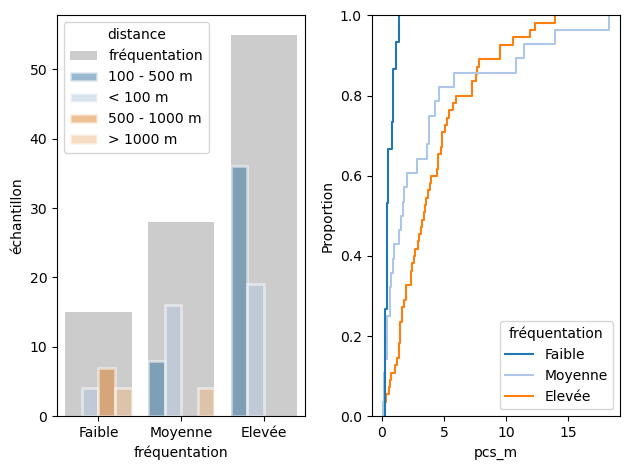

In [32]:
# visual inspection of the feature groups under different use case scenarios
# thes graphs appear under tabs
# usage and distance

fig, ax = plt.subplots(1, 2)

hue_order = ['Faible', 'Moyenne', 'Elevée']
ecdfd = no_combined.groupby(['échantillon', 'fréquentation', 'distance'], as_index=False).pcs_m.sum()

sns.barplot(data=data, x='fréquentation', y='échantillon', color='grey', ax=ax[0], label='fréquentation', order=hue_order, alpha=0.4, zorder=1)
sns.barplot(data=data2, x='fréquentation', y='échantillon', hue='distance',   order=hue_order, edgecolor='white', linewidth=2, palette='tab20', ax=ax[0], alpha=0.5, zorder=2)
caption = "L'utilisation de la plage et la distance jusqu'au parking"
sns.ecdfplot(data=ecdfd, x='pcs_m', ax=ax[1], hue='fréquentation', palette='tab20', hue_order=hue_order)
# ax[1].set_xlim(-.2, 5)
plt.tight_layout()
glue('dist-req', fig, display=True)
plt.close()

In [33]:
# usage and substrate
fig, ax = plt.subplots(1, 2)
operations = {'échantillon':'nunique'}
feature_columns = ['fréquentation']

data = make_categorical_matrix(no_combined.copy(), feature_columns=feature_columns, operations=operations)
data2 = no_combined.groupby(['fréquentation', 'substrat'], as_index=False)['échantillon'].nunique()
ecdfd = no_combined.groupby(['échantillon', 'fréquentation', 'substrat'], as_index=False).pcs_m.sum()

sns.barplot(data=data, x='fréquentation', y='échantillon', color='grey', order=hue_order, ax=ax[0], label='fréquentation', alpha=0.4, zorder=1)
sns.barplot(data=data2, x='fréquentation', y='échantillon', hue='substrat',   edgecolor='white', linewidth=2, palette='tab20', ax=ax[0], order=hue_order, alpha=0.5, zorder=2)
caption = "L'utilisation de la plage et la granularité du substrat"
sns.ecdfplot(data=ecdfd, x='pcs_m', ax=ax[1], hue='fréquentation', palette='tab20', hue_order=hue_order)
# ax[1].set_xlim(-.2, 1)
plt.tight_layout()
glue('freq-sub', fig, display=False)
plt.close()

In [34]:
# usage and urbanization
fig, ax = plt.subplots(1, 2)

operations = {'échantillon':'nunique'}
feature_columns = ['fréquentation']

data = make_categorical_matrix(no_combined.copy(), feature_columns=feature_columns, operations=operations)
data2 = no_combined.groupby(['fréquentation', 'situation'], as_index=False)['échantillon'].nunique()
ecdfd = no_combined.groupby(['échantillon', 'fréquentation', 'situation'], as_index=False).pcs_m.sum()

sns.barplot(data=data, x='fréquentation', y='échantillon', color='grey', order=hue_order, ax=ax[0], label='fréquentation', alpha=0.4, zorder=1)
sns.barplot(data=data2, x='fréquentation', y='échantillon', hue='situation',   hue_order=["Campagne", "Urbain"], edgecolor='white', linewidth=2, palette='tab20', ax=ax[0], order=hue_order, alpha=0.5, zorder=2)

caption = "La distribution du nombre d'échantillons par situation et la fréquentation."
sns.ecdfplot(data=ecdfd, x='pcs_m', ax=ax[1], hue='fréquentation', palette='tab20', hue_order=hue_order)
# ax[1].set_xlim(-.2, 1)
plt.tight_layout()
glue('freq-sit-corr', fig, display=False)
plt.close()

In [35]:
# ! composite variables
# usage and substrate

data = make_categorical_matrix(data=f_comb.copy(), feature_columns=['fréquentation'])
hue_order = ['faible-moyenne', 'Elévée']
ecdfd = f_comb.groupby(['échantillon', 'fréquentation', 'substrat'], as_index=False).pcs_m.sum()

fig, ax = plt.subplots(1, 2)

sns.barplot(data=data, x='fréquentation', y='échantillon', color='grey', order=hue_order, ax=ax[0], label='fréquentation', alpha=0.4, zorder=1)
sns.barplot(data=f_freq_sub, x='fréquentation', y='échantillon', hue='substrat',   hue_order=["Sable", "Graviers"], edgecolor='white', linewidth=2, palette='tab20', ax=ax[0], order=hue_order, alpha=0.5, zorder=2)

caption = "Distribution du nombre d'échantillons par substrat et fréquentation, après fusion du substrat en deux groupes"

sns.ecdfplot(data=ecdfd, x='pcs_m', ax=ax[1], hue='fréquentation', palette='tab20', hue_order=hue_order)
ax[1].set_xlim(-.2, 1)
plt.tight_layout()
glue('freq-sub-cor', fig, display=False)
plt.close()

In [36]:
# usage and distance
fig, ax = plt.subplots(1, 2)

data = make_categorical_matrix(data=f_comb.copy(), feature_columns=['fréquentation'])
ecdfd = f_comb.groupby(['échantillon', 'fréquentation', 'distance'], as_index=False).pcs_m.sum()
hue_order = ['faible-moyenne', 'Elévée']

sns.barplot(data=data, x='fréquentation', y='échantillon', color='grey', order=hue_order, ax=ax[0], label='fréquentation', alpha=0.4, zorder=1)
sns.barplot(data=f_freq_dist, x='fréquentation', y='échantillon', hue='distance',   hue_order=["<= 500 m", "> 500 m"], edgecolor='white', linewidth=2, palette='tab20', ax=ax[0], order=hue_order, alpha=0.5, zorder=2)

caption = "Distribution du nombre d'échantillons par distance au parking et fréquentation, après fusion de la distance en deux groupes."
sns.ecdfplot(data=ecdfd, x='pcs_m', ax=ax[1], hue='fréquentation', palette='tab20', hue_order=hue_order)
ax[1].set_xlim(-.2, 1)
plt.tight_layout()
glue('freq-dist-cor', fig, display=False)
plt.close()

(correlations)=
### Corrélation des conditions de prélèvement

::::{tab-set}

:::{tab-item} Corrélations
:selected:

Comme indiqué précédemment, les plages ayant un taux de fréquentation plus élevé ont également une valeur médiane plus élevée et sont principalement constituées de plages de sable.

Ces variables sont également corrélées. D'après le tableau ci-dessous, il y a une corrélation positive entre la fréquence et la situation. De plus, il y a une corrélation négative entre la distance et l'utilisation.


__Analyse des corrélations: Coefficient de Corrélation de Spearman :__

Il s'agit d'une mesure non paramétrique de la corrélation de rang. Il évalue dans quelle mesure la relation entre deux variables peut être décrite à l'aide d'une fonction monotone. Convient aux données ordinales car il dépend du rang des valeurs plutôt que de leurs magnitudes réelles.

{glue}`macro-correlation-one` 

__Les variables caractéristiques (conditions) sont ordinales.__ C'est-à-dire qu'elles sont classées de la plus faible à la plus forte. Par exemple, du moins fréquenté au plus fréquenté. _Pour le substrat, il s'agit d'une mesure de la taille de l'agrégat qui constitue la plage_.

Un substrat de 1 = sable fin, donc une corrélation négative entre le substrat et la fréquentation est une façon raffinée de dire que les gens aiment aller sur des plages sablonneuses. La corrélation négative entre la distance et la fréquentation signifie probablement que les gens préfèrent ne pas avoir à marcher trop loin.
::: 

:::{tab-item} Fréquentation et distance

{glue}`dist-req`

:::

:::{tab-item} Fréquentation et substrat

{glue}`freq-sub`
::: 

:::{tab-item} Fréquentation et situation

{glue}`freq-sit-corr`
:::

::::

#### Gérer les covariables indépendents

::::{tab-set}

:::{tab-item} Réduction de dimensions
:selected:


Notre intérêt est de prédire les valeurs sur les rives des lacs et de comprendre comment ou si l'une des variables indépendantes a un effet causal sur la variation de la densité des déchets.

La covariance des variables indépendantes peut avoir un effet de confusion sur l'interprétation des résultats et conduire à des prédictions inexactes. Certaines corrélations sont liées aux conditions d'échantillonnage, c'est-à-dire que les plages les plus fréquentées se trouvent dans des zones urbaines ou que les plages de sable sont les plus fréquentées. Il serait très difficile de classer ces corrélations comme causales. 

Pour réduire l'effet de ces corrélations non causatives, nous pouvons combiner certaines variables. Ici, nous avons combiné les variables du substrat et de la distance au parking, passant de quatre catégories à deux dans chaque cas.


__Réduction de dimensions en combinant des sous-groupes.__

1. Création d'une Variable Composite : combiner des covariables en une seule variable composite si elles représentent collectivement un phénomène sous-jacent unique. Cependant, cette approche simplifie le modèle et peut perdre certaines subtilités quant à la façon dont chaque variable affecte indépendamment la réponse.

:::

:::{tab-item} Composition des substrats

{glue}`freq-sub-cor`

Distribution du nombre d'échantillons par substrat et fréquentation, après fusion du substrat en deux groupes et fusion de fréquentation

:::

:::{tab-item} Composition des distances

{glue}`freq-dist-cor`

Distribution du nombre d'échantillons par distance au parking et fréquentation, après fusion de la distance en deux groupes et fusion de fréquentation.
:::

:::: 

In [37]:
def most_common_for_scenario(data, caption, boundaries: dict = boundaries, top_label: list = top_label, language: str = 'fr', lang_maps: dict = language_maps):
    camp_close = rc.ReportClass(data, boundaries=boundaries, language=language, lang_maps=lang_maps, top_label=top_label)
    c_mcommon, weights = camp_close.most_common
    x1 = rc.translated_and_style_for_display(c_mcommon, lang_maps[language], language, gradient=False).set_caption(caption)
    return x1
# Calculating quantiles for Scenario 2
q_uants = [0.01, 0.25, 0.5, 0.75, 0.99]
index = ['1%', '25%', '50%', '75%', '99%', 'Moyenne']

cols = ['échantillon', 'fréquentation','situation', 'distance', 'substrat']

In [38]:
# Filter for Scenario 
test_xi = f_combi[(f_combi['situation'] == 2) & (f_combi['fréquentation'] == 3)].copy()
test_x = test_xi.groupby(cols, as_index=False).pcs_m.sum()
test_x = test_x[['fréquentation', 'situation', 'distance', 'substrat', 'pcs_m']]

# model parameters
estimators = 10
iterations = 500

func = RandomForestRegressor(n_estimators=estimators, criterion="absolute_error", random_state=42)
predictions, feature_importance, mse, r2 =  pstk.analyze_scenario(test_x, func,  n_iterations=iterations)

# the quantiles for this scenario
caption = 'Urban, Fréquentation Elévée'
q_sit_2_freq_3 = pstk.makeqdf(test_x.pcs_m.values, predictions, caption=caption)
glue('q-hf-ville', q_sit_2_freq_3, display=False)

# the most common objects for this scenario
data = test_xi.rename(columns={'échantillon':'loc_date'})
caption = "Les objets les plus courants, situation = ville, fréquentation = élévée"
mcx = most_common_for_scenario(data, caption)
glue('ville-hf-mc', mcx, display=False) 

# the histogram for this scenario:
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions - Situation Ville, Haute Fréquentation'
pstk.plot_histogram(predictions, test_x.pcs_m.values, title=title, reference='ville-hf', display=False)

In [39]:
# Filter for Scenario 
test_xi = f_combi[(f_combi['situation'] == 1) & (f_combi['fréquentation'] == 3)].copy()
test_x = test_xi.groupby(cols, as_index=False).pcs_m.sum()
test_x = test_x[['fréquentation', 'situation', 'distance', 'substrat', 'pcs_m']]

func = RandomForestRegressor(n_estimators=estimators, criterion="absolute_error", random_state=42)
predictions, feature_importance, mse, r2 =  pstk.analyze_scenario(test_x, func,  n_iterations=iterations)

# the quantiles for this scenario
caption="Campagne, Fréquentation Eléveé"
q_sit_1_freq_3 = pstk.makeqdf(test_x.pcs_m.values, predictions, caption=caption)
glue('q-hf-camp', q_sit_1_freq_3, display=False)

# the most common objects for this scenario
data = test_xi.rename(columns={'échantillon':'loc_date'})
mcx = most_common_for_scenario(data, caption)
glue('camp-hf-mc', mcx, display=False) 

# the histogram for this scenario:
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions - Situation Campagne, Haute Fréquentation\n'
pstk.plot_histogram(predictions, test_x.pcs_m.values, title=title, reference='camp-hf', display=False)

In [40]:
# Filter for Scenario 
test_xi = f_combi[(f_combi['situation'] == 1) & (f_combi['distance'] == 1)].copy()
test_x = test_xi.groupby(cols, as_index=False).pcs_m.sum()
test_x = test_x[['fréquentation', 'situation', 'distance', 'substrat', 'pcs_m']]


func = RandomForestRegressor(n_estimators=estimators, criterion="absolute_error", random_state=42)
predictions, feature_importance, mse, r2 =  pstk.analyze_scenario(test_x, func,  n_iterations=iterations)

# the quantiles for this scenario
caption = 'Campagne, <= 500 m du parking'
q_sit_1_d_1 = pstk.makeqdf(test_x.pcs_m.values, predictions, caption=caption)
glue('q-camp-dist_1', q_sit_1_d_1, display=False)

# the most common objects for this scenario
data = test_xi.rename(columns={'échantillon':'loc_date'})
mcx = most_common_for_scenario(data, caption)
glue('camp-dist1-mc', mcx, display=False) 

# the histogram for this scenario:
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions - Situation Campagne, distance < 500 m'
pstk.plot_histogram(predictions, test_x.pcs_m.values, title=title, reference='camp-dist-1', display=False)

In [41]:
# Filter for Scenario 
test_xi = f_combi[(f_combi['situation'] == 2) & (f_combi['distance'] == 1)].copy()
test_x = test_xi.groupby(cols, as_index=False).pcs_m.sum()
test_x = test_x[['fréquentation', 'situation', 'distance', 'substrat', 'pcs_m']]

func = RandomForestRegressor(n_estimators=estimators, criterion="absolute_error", random_state=42)
predictions, feature_importance, mse, r2 =  pstk.analyze_scenario(test_x, func,  n_iterations=iterations)

# the quantiles for this scenario
caption = 'Urban, <= 500 m du parking'
q_sit_2_d_1 = pstk.makeqdf(test_x.pcs_m.values, predictions, caption=caption)
glue('q-ville-dist_1', q_sit_2_d_1, display=False)

# the most common objects for this scenario
data = test_xi.rename(columns={'échantillon':'loc_date'})
mcx = most_common_for_scenario(data, caption)
glue('ville-dist1-mc', mcx, display=False) 

# the histogram for this scenario:
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions - Situation Ville, distance < 500 m'
pstk.plot_histogram(predictions, test_x.pcs_m.values, title=title, reference='ville-dist-1', display=False)

In [42]:
# Filter for Scenario 
test_xi = f_combi[(f_combi['substrat'] == 1)].copy()
test_x = test_xi.groupby(cols, as_index=False).pcs_m.sum()
test_x = test_x[['fréquentation', 'situation', 'distance', 'substrat', 'pcs_m']]
func = RandomForestRegressor(n_estimators=estimators, criterion="absolute_error", random_state=42)
predictions, feature_importance, mse, r2 =  pstk.analyze_scenario(test_x, func,  n_iterations=iterations)

# the quantiles for this scenario
caption = 'Sables'
q_sub_1 = pstk.makeqdf(test_x.pcs_m.values, predictions, caption=caption)
glue('q_subs_1', q_sub_1, display=False)

# the most common objects for this scenario
data = test_xi.rename(columns={'échantillon':'loc_date'})
mcx = most_common_for_scenario(data, caption)
glue('subs_1_mc', mcx, display=False) 

# the histogram for this scenario:
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions - Sables'
pstk.plot_histogram(predictions, test_x.pcs_m.values, title=title, reference='subs_1_hist', display=False)

In [43]:
# Filter for Scenario 
test_xi = f_combi[(f_combi['substrat'] == 2)].copy()
test_x = test_xi.groupby(cols, as_index=False).pcs_m.sum()
test_x = test_x[['fréquentation', 'situation', 'distance', 'substrat', 'pcs_m']]
func = RandomForestRegressor(n_estimators=estimators, criterion="absolute_error", random_state=42)
predictions, feature_importance, mse, r2 =  pstk.analyze_scenario(test_x, func,  n_iterations=iterations)

# the quantiles for this scenario
caption='Graviers'
q_sub_2 = pstk.makeqdf(test_x.pcs_m.values, predictions, caption=caption)
glue('q_subs_2', q_sub_2, display=False)

# the most common objects for this scenario
data = test_xi.rename(columns={'échantillon':'loc_date'})
mcx = most_common_for_scenario(data, caption)
glue('subs_2_mc', mcx, display=False) 

# the histogram for this scenario:
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions - Graviers'
pstk.plot_histogram(predictions, test_x.pcs_m.values, title=title, reference='subs_2_hist', display=False)

In [44]:
# Filter for Scenario 
# This is all the values => no filter
# just aggregating to the sample_id 
test_xi = f_combi.copy()
test_x = test_xi.groupby(cols, as_index=False).pcs_m.sum()

func = RandomForestRegressor(n_estimators=estimators, criterion="absolute_error", random_state=42)
predictions, feature_importance, mse, r2 =  pstk.analyze_scenario(test_x, func,  n_iterations=iterations)

# the quantiles for this scenario
caption = 'Toutes les conditions'
q_tous = pstk.makeqdf(test_x.pcs_m.values, predictions, caption=caption)
glue('q-tous', q_tous, display=False)

# the most common objects for this scenario
data = test_xi.rename(columns={'échantillon':'loc_date'})
mcx = most_common_for_scenario(data, caption)
glue('tous-mc', mcx, display=False) 

# the histogram for this scenario:
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions'
pstk.plot_histogram(predictions, test_x.pcs_m.values, title=title, reference='tous', display=False)

(random_forest)=
### Régression avec Forêt Aléatoire (Random Forest Regression)

Source : [scikit-learn random forest](https://scikit-learn.org/0.16/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

criterion : `absolute error`

La régression avec forêt aléatoire est une technique d'apprentissage automatique (machine learning) utilisée pour prédire des résultats continus (par opposition aux catégories dans la classification). C'est une méthode d'apprentissage ensembliste, ce qui signifie qu'elle combine les prédictions de plusieurs algorithmes d'apprentissage automatique pour produire des prédictions plus précises.

::::{tab-set}

:::{tab-item} Toutes les conditions
{glue}`tous`

|Plus courants|Quantiles|
|:-:|:-:|
|{glue}`tous-mc`|{glue}`q-tous`|
:::

:::{tab-item} Graviers
{glue}`subs_2_hist`

|Plus courants|Quantiles|
|:-:|:-:|
|{glue}`subs_2_mc`|{glue}`q_subs_2`|
:::

:::{tab-item} Sables
{glue}`subs_1_hist`

|Plus courants|Quantiles|
|:-:|:-:|
|{glue}`subs_1_mc`|{glue}`q_subs_1`|
:::

:::{tab-item} Ville et haute Fréquentation
{glue}`ville-hf`

|Plus courants|Quantiles|
|:-:|:-:|
|{glue}`ville-hf-mc`|{glue}`q-hf-ville`|
:::

:::{tab-item} Campagne et haute fréquentation
{glue}`camp-hf`

|Plus courants|Quantiles|
|:-:|:-:|
|{glue}`camp-hf-mc`|{glue}`q-hf-camp`|
:::

:::{tab-item} Campagne et parking <= 500 m
{glue}`camp-dist-1`

|Plus courants|Quantiles|
|:-:|:-:|
|{glue}`camp-dist1-mc`|{glue}`q-camp-dist_1`|
:::

:::{tab-item} Ville et parking <= 500 m
{glue}`ville-dist-1`

|Plus courants|Quantiles|
|:-:|:-:|
|{glue}`ville-dist1-mc`|{glue}`q-ville-dist_1`|
:::



:::{tab-item} Résultats
:selected:

````{grid} 1 2 2 2

```{grid-item}
{glue}`q-tous`
```

```{grid-item}

Les modèles ont fait l'objet d'un bootstrap, 100 itérations pour chaque scénario. Les résultats estimés sont la collection de toutes les prédictions de chaque itération.

Par exemple, le tableau intitulé "Gravier" présente les résultats observés et prévus pour les plages ayant un substrat de 3 ou 4.

```

```{grid-item}
{glue}`q_subs_2`
```

```{grid-item}
{glue}`q_subs_1`
```

```{grid-item}
{glue}`q-hf-ville`
```

```{grid-item}
{glue}`q-hf-camp`
```

```{grid-item}
{glue}`q-camp-dist_1`
```

```{grid-item}
{glue}`q-ville-dist_1`
```

````
:::

::::
    




<!-- 
::::{tab-set}

:::{tab-item} Modèles
:selected:

La régression avec forêt aléatoire est une technique d'apprentissage automatique (machine learning) utilisée pour prédire des résultats continus (par opposition aux catégories dans la classification). C'est une méthode d'apprentissage ensembliste, ce qui signifie qu'elle combine les prédictions de plusieurs algorithmes d'apprentissage automatique pour produire des prédictions plus précises que n'importe quel modèle individuel.

Basée sur des __Arbres de Décision__ : Une forêt aléatoire est composée de nombreux arbres de décision, qui sont des modèles simples faisant des prédictions basées sur une série de choix binaires. Chaque arbre dans une forêt aléatoire donne une prédiction, et la forêt aléatoire combine ces prédictions pour produire un résultat plus précis.

|Tous|Sable|
|:-:|:-:|
|{glue}`q-tous`|{glue}`q_subs_2`

:::

:::{tab-item} Tous les variables
{glue}`tous`

|Plus courants|Quantiles|
|:-:|:-:|
|{glue}`tous-mc`|{glue}`q-tous`|
:::

:::{tab-item} Sabloneuse
{glue}`subs_2_hist`

|Plus courants|Quantiles|
|:-:|:-:|
|{glue}`subs_2_mc`|{glue}`q_subs_2`|
:::

:::{tab-item} Graviers
{glue}`subs_1_hist`

|Plus courants|Quantiles|
|:-:|:-:|
|{glue}`subs_1_mc`|{glue}`q_subs_1`|
:::

:::{tab-item} Ville et haute Fréquentation
{glue}`ville-hf`

|Plus courants|Quantiles|
|:-:|:-:|
|{glue}`ville-hf-mc`|{glue}`q-hf-ville`|
:::

:::{tab-item} Campagne et haute fréquentation
{glue}`camp-hf`

|Plus courants|Quantiles|
|:-:|:-:|
|{glue}`camp-hf-mc`|{glue}`q-hf-camp`|
:::

:::{tab-item} Campagne et parking < 500 m
{glue}`camp-dist-1`

|Plus courants|Quantiles|
|:-:|:-:|
|{glue}`camp-dist1-mc`|{glue}`q-camp-dist_1`|
:::

:::{tab-item} Ville et parking < 500 m
{glue}`ville-dist-1`

|Plus courants|Quantiles|
|:-:|:-:|
|{glue}`ville-dist1-mc`|{glue}`q-ville-dist_1`|
:::
:::: -->

In [45]:
grid_val_index = np.linspace(0, 19.99, 2000)
groupby_columns = ['sample_id', 'location', 'date', 'city', 'orchards', 'vineyards', 'buildings', 'forest',
                   'undefined', 'public_services', 'streets']


In [46]:
# the prior data from surveys
iqaasl_prior = report_iq_pk.w_df[report_iq_pk.w_df.project == "IQAASL"].copy()
iq_p = iqaasl_prior.groupby(['loc_date', 'project'], as_index=False).pcs_m.sum()
iq_p['top'] = 1

iq_prior = pstk.calculate_likelihood(aggregated_data=iq_p, bin_density_column='top', pcs_column='pcs_m', grid_range=grid_val_index, bins=[1])
iq_prior.rename(columns={'Likelihood_1':'Bin_1'}, inplace=True)

col = 'top'
pcs_col = 'pcs_m'
grid_range = grid_val_index
bins = [1]

# assuming know prior knowledge
beta_prior = pstk.calculate_beta_prior(grid_range=grid_range, bin_density_numbers=[1])
    


test_x = f_combi.copy().groupby(cols, as_index=False).pcs_m.sum()
test_x['top'] = 1

grid_pstock = pstk.calculate_likelihood(aggregated_data=test_x, bin_density_column=col, pcs_column=pcs_col, grid_range=grid_range, bins=bins)

In [47]:
# posterior uninformed
post_grid_pstock = pstk.define_posterior(grid_pstock, beta_prior, grid_val_index=grid_range)

# posterior informed
post_grid_iqp =pstk.define_posterior(grid_pstock, iq_prior, grid_val_index=grid_range)

# samples
sample_totals = pstk.posterior_predictions(post_grid_pstock.copy())
s_iqp = pstk.posterior_predictions(post_grid_iqp.copy())

caption = 'Toutes les conditions'

test_grid_quants = pstk.makeqdf(test_x.pcs_m.values, s_iqp, caption=caption)
glue('q-tous-b', test_grid_quants, display=False)
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions: toutes les conditions,  grid approximation, prior = IQAASL'

pstk.plot_histogram(s_iqp, test_x.pcs_m.values, title=title, reference='toutes-gapprox', display=False)

In [48]:
col = 'substrat'
pcs_col = 'pcs_m'
grid_range = grid_val_index
bins = [2]

test_xi = f_combi[(f_combi['substrat'] == 2)].copy()
test_x = test_xi.groupby(cols, as_index=False).pcs_m.sum()


grid_pstock = pstk.calculate_likelihood(aggregated_data=test_x, bin_density_column=col, pcs_column=pcs_col, grid_range=grid_range, bins=bins)

# posterior uninformed
post_grid_pstock = pstk.define_posterior(grid_pstock, beta_prior, grid_val_index=grid_range)

# posterior informed
post_grid_iqp =pstk.define_posterior(grid_pstock, iq_prior, grid_val_index=grid_range)

# samples
sample_totals = pstk.posterior_predictions(post_grid_pstock.copy())
s_iqp = pstk.posterior_predictions(post_grid_iqp.copy())

caption = 'Graviers'

test_grid_quants = pstk.makeqdf(test_x.pcs_m.values, sample_totals, caption=caption)
glue('q-gravier-b', test_grid_quants, display=False)
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions: Graviers, grid approximation, prior = IQAASL'

pstk.plot_histogram(sample_totals, test_x.pcs_m.values, title=title, reference='graviers-gapprox', display=False)

In [49]:
col = 'substrat'
pcs_col = 'pcs_m'
grid_range = grid_val_index
bins = [1]

test_xi = f_combi[(f_combi['substrat'] == 1)].copy()
test_x = test_xi.groupby(cols, as_index=False).pcs_m.sum()


grid_pstock = pstk.calculate_likelihood(aggregated_data=test_x, bin_density_column=col, pcs_column=pcs_col, grid_range=grid_range, bins=bins)

# posterior uninformed
post_grid_pstock = pstk.define_posterior(grid_pstock, beta_prior, grid_val_index=grid_range)

# posterior informed
post_grid_iqp =pstk.define_posterior(grid_pstock, iq_prior, grid_val_index=grid_range)

# samples
sample_totals = pstk.posterior_predictions(post_grid_pstock.copy())
s_iqp = pstk.posterior_predictions(post_grid_iqp.copy())

caption = 'Sable'

test_grid_quants = pstk.makeqdf(test_x.pcs_m.values, sample_totals, caption=caption)
glue('q-sable-b', test_grid_quants, display=False)
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions: Sable, grid approximation, prior = IQAASL'

pstk.plot_histogram(sample_totals, test_x.pcs_m.values, title=title, reference='sables-gapprox', display=False)

In [50]:
col = 'fréquentation'
pcs_col = 'pcs_m'
grid_range = grid_val_index
bins = [3]

test_xi = f_combi[(f_combi['situation'] == 2) & (f_combi['fréquentation'] == 3)].copy()
test_x = test_xi.groupby(cols, as_index=False).pcs_m.sum()


grid_pstock = pstk.calculate_likelihood(aggregated_data=test_x, bin_density_column=col, pcs_column=pcs_col, grid_range=grid_range, bins=bins)

# posterior uninformed
post_grid_pstock = pstk.define_posterior(grid_pstock, beta_prior, grid_val_index=grid_range)

# posterior informed
post_grid_iqp =pstk.define_posterior(grid_pstock, iq_prior, grid_val_index=grid_range)

# samples
sample_totals = pstk.posterior_predictions(post_grid_pstock.copy())
s_iqp = pstk.posterior_predictions(post_grid_iqp.copy())

caption = 'Ville et haut fréquentation'

test_grid_quants = pstk.makeqdf(test_x.pcs_m.values, sample_totals, caption=caption)
glue('q-v-hf-b', test_grid_quants, display=False)
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions: Ville et haut fréquentation, grid approximation'

pstk.plot_histogram(sample_totals, test_x.pcs_m.values, title=title, reference='v-hf-gapprox', display=False)

In [51]:
col = 'fréquentation'
pcs_col = 'pcs_m'
grid_range = grid_val_index
bins = [3]

test_xi = f_combi[(f_combi['situation'] == 1) & (f_combi['fréquentation'] == 3)].copy()
test_x = test_xi.groupby(cols, as_index=False).pcs_m.sum()


grid_pstock = pstk.calculate_likelihood(aggregated_data=test_x, bin_density_column=col, pcs_column=pcs_col, grid_range=grid_range, bins=bins)

# posterior uninformed
post_grid_pstock = pstk.define_posterior(grid_pstock, beta_prior, grid_val_index=grid_range)

# posterior informed
post_grid_iqp =pstk.define_posterior(grid_pstock, iq_prior, grid_val_index=grid_range)

# samples
sample_totals = pstk.posterior_predictions(post_grid_pstock.copy())
s_iqp = pstk.posterior_predictions(post_grid_iqp.copy())

caption = 'Campagne et haut fréquentation'

test_grid_quants = pstk.makeqdf(test_x.pcs_m.values, sample_totals, caption=caption)
glue('q-cam-hf-b', test_grid_quants, display=False)
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions: Campagne et haut fréquentation, grid approximation'

pstk.plot_histogram(sample_totals, test_x.pcs_m.values, title=title, reference='cam-hf-gapprox', display=False)

In [52]:
col = 'situation'
pcs_col = 'pcs_m'
grid_range = grid_val_index
bins = [2]

test_xi = f_combi[(f_combi['situation'] == 2) & (f_combi['distance'] == 1)].copy()
test_x = test_xi.groupby(cols, as_index=False).pcs_m.sum()


grid_pstock = pstk.calculate_likelihood(aggregated_data=test_x, bin_density_column=col, pcs_column=pcs_col, grid_range=grid_range, bins=bins)

# posterior uninformed
post_grid_pstock = pstk.define_posterior(grid_pstock, beta_prior, grid_val_index=grid_range)

# posterior informed
post_grid_iqp =pstk.define_posterior(grid_pstock, iq_prior, grid_val_index=grid_range)

# samples
sample_totals = pstk.posterior_predictions(post_grid_pstock.copy())
s_iqp = pstk.posterior_predictions(post_grid_iqp.copy())

caption = 'Ville et distance <= 500 m'

test_grid_quants = pstk.makeqdf(test_x.pcs_m.values, sample_totals, caption=caption)
glue('q-v-dist1-b', test_grid_quants, display=False)
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions: Ville et distance <= 500 m, grid approximation, prior = IQAASL'

pstk.plot_histogram(sample_totals, test_x.pcs_m.values, title=title, reference='v-dist1-gapprox', display=False)

In [53]:
col = 'situation'
pcs_col = 'pcs_m'
grid_range = grid_val_index
bins = [1]

test_xi = f_combi[(f_combi['situation'] == 1) & (f_combi['distance'] == 1)].copy()
test_x = test_xi.groupby(cols, as_index=False).pcs_m.sum()


grid_pstock = pstk.calculate_likelihood(aggregated_data=test_x, bin_density_column=col, pcs_column=pcs_col, grid_range=grid_range, bins=bins)

# posterior uninformed
post_grid_pstock = pstk.define_posterior(grid_pstock, beta_prior, grid_val_index=grid_range)

# posterior informed
post_grid_iqp =pstk.define_posterior(grid_pstock, iq_prior, grid_val_index=grid_range)

# samples
sample_totals = pstk.posterior_predictions(post_grid_pstock.copy())
s_iqp = pstk.posterior_predictions(post_grid_iqp.copy())

caption = 'Campagne et distance <= 500 m'

test_grid_quants = pstk.makeqdf(test_x.pcs_m.values, sample_totals, caption=caption)
glue('q-c-dist1-b', test_grid_quants, display=False)
title = 'Plastock 2022, Le Léman\nDistribution des Prédictions: Campagne et distance <= 500 m, grid approximation, prior = IQAASL'

pstk.plot_histogram(sample_totals, test_x.pcs_m.values, title=title, reference='c-dist1-gapprox', display=False)

__Approximation Bayésienne par Grille__



(grid_approx)=
### Approximation Bayésienne par Grille

Source : [hammerdirt](https://hammerdirt-analyst.github.io/feb_2024/titlepage.html)

application : [solid-waste-team](https://hammerdirt-analyst.github.io/solid-waste-team/grid_approximation.html)

prior : Résultats de la campagne d'échantillonnage précédente

Cas d'utilisation : Cette méthode est une approche manuelle de l'inférence Bayésienne. Elle est particulièrement utile lorsque vous souhaitez incorporer des croyances antérieures et mettre à jour ces croyances avec des données observées.

Mise en œuvre : Implique la définition d'une grille de valeurs de paramètres et le calcul de la vraisemblance des données observées à chaque point de cette grille. En multipliant par la probabilité a priori et en normalisant, on obtient la distribution a posteriori. Cela peut être fait pour chaque condition séparément ou pour toutes les conditions ensemble, bien que cela soit plus intensif en termes de calcul.



::::{tab-set}

:::{tab-item} Toutes les conditions
{glue}`toutes-gapprox`
:::

:::{tab-item} Graviers
{glue}`graviers-gapprox`
:::

:::{tab-item} Sables
{glue}`sables-gapprox`

:::

:::{tab-item} Ville et haute Fréquentation
{glue}`v-hf-gapprox`

:::

:::{tab-item} Campagne et haute fréquentation
{glue}`cam-hf-gapprox`

:::

:::{tab-item} Campagne et parking <= 500 m
{glue}`c-dist1-gapprox`

:::

:::{tab-item} Ville et parking <= 500 m
{glue}`v-dist1-gapprox`

:::



:::{tab-item} Résultats
:selected:

````{grid} 1 2 2 2

```{grid-item}
{glue}`q-tous-b`
```

```{grid-item}

Prédictions : Fournit une distribution de valeurs possibles de pcs/m, offrant une idée de la fourchette et de l'incertitude des prédictions. Particulièrement utile lorsque la prise de décision nécessite de comprendre l'incertitude ou la variabilité des prédictions.

```

```{grid-item}
{glue}`q-gravier-b`
```

```{grid-item}
{glue}`q-sable-b`
```

```{grid-item}
{glue}`q-v-hf-b`
```

```{grid-item}
{glue}`q-cam-hf-b`
```

```{grid-item}
{glue}`q-c-dist1-b`
```

```{grid-item}
{glue}`q-v-dist1-b`
```

````
:::

::::
    

## Inventaire Plastock.

In [54]:
t = rc.translate_for_display(plastock_report.inventory, amap=language_maps['fr'], lan='fr')
t['objet'] = t.code.apply(lambda x: codes.loc[x, 'fr'])
t = t[[t.columns[0], t.columns[-1], *t.columns[1:-1]]]
t.set_index(['code', 'objet'], inplace=True)
t.index.name = None
t.style.set_table_styles(table_css_styles).format(**psc.format_kwargs)

,,quantité,% du total,pcs/m,taux d'échec
code,objet,,,,
Gfrags,"Fragments de plastique: g80, g79, g78, g77, g76, g75",11'221,"0,41","0,72","0,97"
G27,Mégots et filtres à cigarettes,3'089,"0,11","0,15","0,79"
G30,"Emballages de bonbons, de snacks",2'080,"0,08","0,15","0,74"
G106,Fragments de plastique angulaires <5mm,1'926,"0,07","0,00","0,41"
G112,Pellets industriels (GPI),1'526,"0,06","0,00","0,36"
Gfoams,"Fragments de polystyrène expansé: g81, g82, g83",1'399,"0,05","0,07","0,72"
Gcaps,"Couvercles en plastique bouteille: G21, G22, G23, G24",1'070,"0,04","0,04","0,65"
G95,Coton-tige,1'040,"0,04","0,03","0,54"
G74,Mousse de plastique pour l'isolation thermique,406,"0,01","0,00","0,38"


In [55]:
%watermark --iversions -b -r

Git repo: https://github.com/hammerdirt-analyst/plastock.git

Git branch: main

matplotlib: 3.7.1
seaborn   : 0.12.2
numpy     : 1.24.2
pandas    : 2.0.0

